# Loan Default Prediction

In this scenario you are tasked with formulating a rule set to classify high-risk loan applicants (an applicant likely to fail to pay back a loan).  You are free to quantify what "high-risk" means and what types of rules are used.  The important thing is to _quantify the value of your rules_.

Therefore, an important part of our task is to quantify the effectiveness of the current practice (loan Grade and Subgrade).   Our conclusion should either propose changes that add value, or validate the current practice and show it is not practical to change it.   

This execise is inspired by the very recent release of Lending Club Loan Data from 2007-2015.  We will use it to build a Loan default predictor.  You can download the data here:

https://www.kaggle.com/wendykan/lending-club-loan-data

You can see the LendingClub website here:

https://www.lendingclub.com/

Check out "Browse Loans" to see how the business works.

I've left the code in this notebook as close as possible to my original first-pass, stream-of-conciousness analysis. 


In [2]:
import pandas
%matplotlib inline
# allows plotting in cells, we'll use later on.
import pylab
pylab.rcParams['figure.figsize'] = (10, 6) # set a larger figure size

Read the Excel data dictionary (it's nice to have it here).  You need to install the `xlrd` module first.  Windows: from the command prompt, go to your Anaconda python directory (you will see `python.exe` there) and:

`python -m pip install xlrd`  

Under Linux, from anywhere: `sudo -H python -m pip install xlrd`

In [3]:
import xlrd

In [5]:
df_dictionary = pandas.read_excel('~/pers/mlClass/data/lendingclub/LCDataDictionary.xlsx')

In [6]:
df_dictionary

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan...
1,annual_inc,The self-reported annual income provided by th...
2,annual_inc_joint,The combined self-reported annual income provi...
3,application_type,Indicates whether the loan is an individual ap...
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding m...
6,delinq_2yrs,The number of 30+ days past-due incidences of ...
7,desc,Loan description provided by the borrower
8,dti,A ratio calculated using the borrower’s total ...
9,dti_joint,A ratio calculated using the co-borrowers' tot...


In [9]:
df_dictionary.iloc[20].Description

u'The initial listing status of the loan. Possible values are \u2013 W, F'

In [7]:
import sqlite3
conn = sqlite3.connect('/Users/pfigliozzi/pers/mlclass/data/lendingclub/database.sqlite')

Find out the table name(s)

In [8]:
query = """
SELECT name FROM sqlite_master WHERE type='table'
"""
response = conn.execute(query)
response.fetchall()

[(u'loan',)]

Get an idea of the data format

In [9]:
query = """
SELECT * FROM loan LIMIT 5
"""
df_sample = pandas.read_sql(query, conn)
with pandas.option_context('display.max_columns', 75):
    print df_sample

   index       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0      0  1077501  1296599.0     5000.0       5000.0           4975.0   
1      1  1077430  1314167.0     2500.0       2500.0           2500.0   
2      2  1077175  1313524.0     2400.0       2400.0           2400.0   
3      3  1076863  1277178.0    10000.0      10000.0          10000.0   
4      4  1075358  1311748.0     3000.0       3000.0           3000.0   

         term int_rate  installment grade sub_grade                 emp_title  \
0   36 months   10.65%       162.87     B        B2                      None   
1   60 months   15.27%        59.83     C        C4                     Ryder   
2   36 months   15.96%        84.33     C        C5                      None   
3   36 months   13.49%       339.31     C        C1       AIR RESOURCES BOARD   
4   60 months   12.69%        67.79     B        B5  University Medical Group   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0

Is it one entry (id) for life of the loan?

In [10]:
df_sample.id[0]

u'1077501'

In [11]:
query = """
SELECT * FROM loan WHERE id = '1077501'
"""
df_sample = pandas.read_sql(query, conn)
df_sample

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,None,None,None,None,None,None,None,None,None,None


In [12]:
query = """
SELECT id,COUNT(*) as count FROM loan GROUP BY id ORDER BY count DESC;
"""
df_count = pandas.read_sql(query, conn)
df_count.head()

,id,count
0,1000007,1
1,1000030,1
2,1000033,1
3,1000045,1
4,1000067,1


Our classifier will be used to rate loans before funding, so we have to be careful to pick fields that were known at loan origination for our classifer.  At this point, we would need to have a discussion with the IT folks about what fields would qualify.  Let's assume they said every field is from loan origination, except: 
   * totals such as total_pymnt, total_rec_late_fee, etc.
   * last and next payment dates, last credit pull date

# Data selection and cleaning

The full database is 492MB.  It will fit entirely in memory. No real need to subset using a SQL query.  I like to explicitly select out columns I'm thinking of using right now.  It helps organize my thought process. 

The database read, from disk, takes about a minute.  From my SSD, a < 10 seconds.

Note From The Future: I ran into some `Memory Error` problems on my 32-bit, 6GB linux box.  I solved these by restarting the kernel and re-running the notebook.


In [13]:
query = """
SELECT 
    id,
    member_id,
    funded_amnt_inv,
    funded_amnt,
    int_rate,
    installment,
    grade,
    sub_grade,
    emp_length,
    home_ownership,
    annual_inc,
    issue_d,
    loan_status,
    purpose,
    desc,
    dti,
    earliest_cr_line,
    inq_last_6mths,
    mths_since_last_delinq,
    open_acc,
    revol_bal,
    revol_util,
    total_acc,
    total_pymnt,
    total_rec_prncp,
    total_rec_int,
    total_rec_late_fee,
    application_type

FROM loan
"""

df = pandas.read_sql(query, conn)

In [14]:
df.describe()

,member_id,funded_amnt_inv,funded_amnt,installment,annual_inc,dti,inq_last_6mths,mths_since_last_delinq,open_acc,revol_bal,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee
count,8.873820e+05,887382.000000,887382.000000,887382.000000,8.873780e+05,887382.00000,887353.000000,433069.000000,887353.000000,8.873820e+05,887353.000000,887382.000000,887382.000000,887382.000000,887382.000000
mean,3.500184e+07,14702.480039,14741.893147,436.717647,7.502761e+04,18.15702,0.694622,34.063697,11.548471,1.692076e+04,25.268032,7558.831876,5757.706058,1754.810042,0.396690
std,2.411336e+07,8442.107612,8429.898507,244.186619,6.469823e+04,17.19060,0.998447,21.884941,5.317310,2.242676e+04,11.840553,7871.238570,6625.433555,2095.368371,4.087818
min,7.047300e+04,0.000000,500.000000,15.670000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.087713e+07,8000.000000,8000.000000,260.710000,4.500000e+04,11.91000,0.000000,15.000000,8.000000,6.443000e+03,17.000000,1914.590000,1200.570000,441.460000,0.000000
50%,3.709528e+07,13000.000000,13000.000000,382.550000,6.500000e+04,17.65000,0.000000,31.000000,11.000000,1.187500e+04,24.000000,4894.999559,3215.320000,1073.280000,0.000000
75%,5.847135e+07,20000.000000,20000.000000,572.600000,9.000000e+04,23.95000,1.000000,50.000000,14.000000,2.082900e+04,32.000000,10616.857115,8000.000000,2238.267500,0.000000
max,7.354484e+07,35000.000000,35000.000000,1445.460000,9.500000e+06,9999.00000,33.000000,188.000000,90.000000,2.904836e+06,169.000000,57777.579870,35000.030000,24205.620000,358.680000


In [15]:
df.head()

,id,member_id,funded_amnt_inv,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,mths_since_last_delinq,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,application_type
0,1077501,1296599.0,4975.0,5000.0,10.65%,162.87,B,B2,10+ years,RENT,...,NaN,3.0,13648.0,83.7%,9.0,5861.071414,5000.00,861.07,0.00,INDIVIDUAL
1,1077430,1314167.0,2500.0,2500.0,15.27%,59.83,C,C4,< 1 year,RENT,...,NaN,3.0,1687.0,9.4%,4.0,1008.710000,456.46,435.17,0.00,INDIVIDUAL
2,1077175,1313524.0,2400.0,2400.0,15.96%,84.33,C,C5,10+ years,RENT,...,NaN,2.0,2956.0,98.5%,10.0,3003.653644,2400.00,603.65,0.00,INDIVIDUAL
3,1076863,1277178.0,10000.0,10000.0,13.49%,339.31,C,C1,10+ years,RENT,...,35.0,10.0,5598.0,21%,37.0,12226.302212,10000.00,2209.33,16.97,INDIVIDUAL
4,1075358,1311748.0,3000.0,3000.0,12.69%,67.79,B,B5,1 year,RENT,...,38.0,15.0,27783.0,53.9%,38.0,3242.170000,2233.10,1009.07,0.00,INDIVIDUAL


In [16]:
df.set_index('id', inplace=True)
df.head()

,member_id,funded_amnt_inv,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,mths_since_last_delinq,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,application_type
id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599.0,4975.0,5000.0,10.65%,162.87,B,B2,10+ years,RENT,24000.0,...,NaN,3.0,13648.0,83.7%,9.0,5861.071414,5000.00,861.07,0.00,INDIVIDUAL
1077430,1314167.0,2500.0,2500.0,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,...,NaN,3.0,1687.0,9.4%,4.0,1008.710000,456.46,435.17,0.00,INDIVIDUAL
1077175,1313524.0,2400.0,2400.0,15.96%,84.33,C,C5,10+ years,RENT,12252.0,...,NaN,2.0,2956.0,98.5%,10.0,3003.653644,2400.00,603.65,0.00,INDIVIDUAL
1076863,1277178.0,10000.0,10000.0,13.49%,339.31,C,C1,10+ years,RENT,49200.0,...,35.0,10.0,5598.0,21%,37.0,12226.302212,10000.00,2209.33,16.97,INDIVIDUAL
1075358,1311748.0,3000.0,3000.0,12.69%,67.79,B,B5,1 year,RENT,80000.0,...,38.0,15.0,27783.0,53.9%,38.0,3242.170000,2233.10,1009.07,0.00,INDIVIDUAL


# Data characterization

Let's first think about value.  We want to focus on an area where we can make an impact.  Where's the money?  This is the most important part of our analysis.

In [17]:
g = df.groupby(['grade', 'sub_grade'])
type(g)

pandas.core.groupby.DataFrameGroupBy

In [18]:
g.describe()

annual_inc                                                  \
                     count          mean            std      min       25%   
grade sub_grade                                                              
A     A1           22914.0  94667.997979   60642.985209   6000.0  60000.00   
      A2           22484.0  86775.748776   69926.322045   3500.0  54000.00   
      A3           23455.0  87368.323245  117418.805938   3300.0  52000.00   
      A4           34531.0  85001.434609   77320.912102   6000.0  50400.00   
      A5           44815.0  84349.170777   78857.805881   5500.0  51000.00   
B     B1           44972.0  78840.572848   76684.810817   7200.0  49000.00   
      B2           48781.0  77159.632128   68885.454235   2000.0  48000.00   
      B3           56323.0  76010.256196   60738.806744   4800.0  46000.00   
      B4           55626.0  74347.197354   68874.860766   5000.0  45500.00   
      B5           48833.0  71424.600070   48902.586632   3600.0  44720.00   
C     C1           53387.0  71840.377320   61903.556803   4000.0  44000.00   
      C2           52236.0  71369.393309   64327.456574      0.0  43963.50   
      C3           50161.0  72263.317633   65550.088730   4500.0  45000.00   
      C4           48857.0  71433.147730   47671.218441   3000.0  45000.00   
      C5           41219.0  70595.384980   47477.138932   4800.0  43000.00   
D     D1           36238.0  69206.574139   71728.774703   4800.0  42000.00   
      D2           29803.0  67709.173138   45222.217028   4800.0  42000.00   
      D3           26555.0  68285.730719   44937.440890      0.0  42000.00   
      D4           25558.0  70586.374365   52086.924565   3600.0  43600.50   
      D5           21389.0  70542.670690   47970.829978   1770.0  43000.00   
E     E1           18268.0  71057.605190   46082.726333   7000.0  45000.00   
      E2           17004.0  72848.213096   79048.876203   3000.0  45000.00   
      E3           14134.0  71059.961878   46210.165420   4000.0  45000.00   
      E4           11724.0  73214.347806   72663.609929   1200.0  45000.00   
      E5            9575.0  73072.250275   49775.261167   4200.0  45000.00   
F     F1            7219.0  73113.911901   47024.540324   7740.0  45000.00   
      F2            5392.0  74362.376202   47564.851921   4524.0  47000.00   
      F3            4433.0  72296.796553   46625.765049   7280.0  45000.00   
      F4            3409.0  73711.507152   50361.343154   7200.0  47000.00   
      F5            2594.0  77257.631253   55542.824077   4800.0  49999.25   
G     G1            1871.0  77140.744821   54355.228316   9624.0  48000.00   
      G2            1398.0  76145.586259   53633.759099   8000.0  48000.00   
      G3             981.0  81247.227003   64622.306445   1896.0  49643.00   
      G4             663.0  85804.822851   64051.521997   8796.0  50000.00   
      G5             576.0  88927.628108   66841.273785  11000.0  55000.00   

                                                    dti               ...     \
                     50%        75%        max    count       mean    ...      
grade sub_grade                                                       ...      
A     A1         82000.0  112486.25  1700000.0  22914.0  14.253122    ...      
      A2         75000.0  103000.00  5000010.0  22485.0  15.166314    ...      
      A3         75000.0  101400.00  9000000.0  23457.0  15.679835    ...      
      A4         72000.0  100000.00  7000000.0  34531.0  15.758522    ...      
      A5         72000.0  100000.00  9500000.0  44816.0  16.267420    ...      
B     B1         68000.0   95000.00  8121180.0  44972.0  16.719337    ...      
      B2         65000.0   92000.00  8500021.0  48781.0  16.883906    ...      
      B3         65000.0   90000.00  6100000.0  56323.0  17.284779    ...      
      B4         64763.5   90000.00  8700000.0  55626.0  17.604912    ...      
      B5         60000.0   85000.00  2300000.0  48833.0  17.947292    ...      
C     C1   

Let's plot out the total received interest by grade & sub-grade; first understand the data structure we're creating

In [19]:
x=g['total_rec_int'].sum()
type(x)

pandas.core.series.Series

In [20]:
x

grade  sub_grade
A      A1           1.288429e+07
       A2           1.483234e+07
       A3           1.925414e+07
       A4           3.093603e+07
       A5           4.354043e+07
B      B1           4.495163e+07
       B2           5.849451e+07
       B3           7.577072e+07
       B4           8.079421e+07
       B5           6.643680e+07
C      C1           7.938202e+07
       C2           8.565343e+07
       C3           8.923623e+07
       C4           9.232545e+07
       C5           8.649048e+07
D      D1           7.476157e+07
       D2           6.581057e+07
       D3           6.162788e+07
       D4           6.658288e+07
       D5           5.969734e+07
E      E1           5.157045e+07
       E2           5.209222e+07
       E3           4.467452e+07
       E4           4.049532e+07
       E5           3.454093e+07
F      F1           2.791445e+07
       F2           2.246921e+07
       F3           1.866930e+07
       F4           1.557349e+07
       F5           1.2410

It's a Pandas series; therefore, it's got a plot() method.

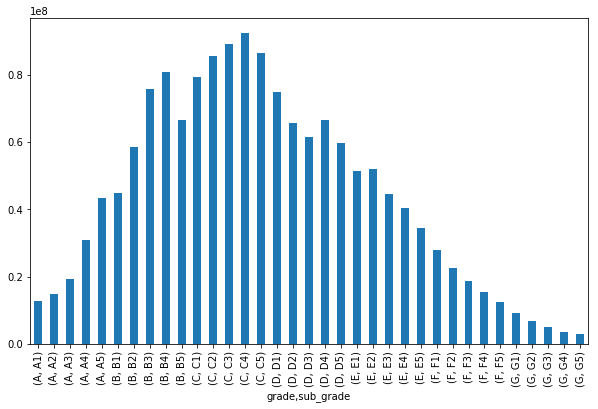

In [21]:
g['total_rec_int'].sum().plot(kind='bar')

Also plot the late fees collected.  It turns out-- not so much, compared to interest.

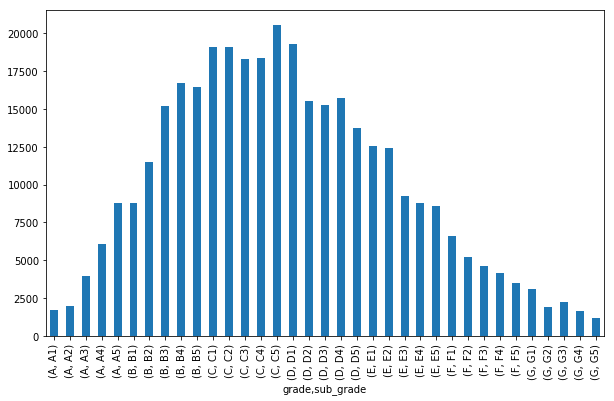

In [22]:
g['total_rec_late_fee'].sum().plot(kind='bar')

Most of the revenues are made from interest on the grade C loans. Not much money is made in late fees.  On the interest chart, there is an interesting sub-peak in B4-B5.  

Next we must realize that these are all data since 2007.  Has the money always been in C loans, or has that changed over time?

In [23]:
df.issue_d.unique()

array([u'Dec-2011', u'Nov-2011', u'Oct-2011', u'Sep-2011', u'Aug-2011',
       u'Jul-2011', u'Jun-2011', u'May-2011', u'Apr-2011', u'Mar-2011',
       u'Feb-2011', u'Jan-2011', u'Dec-2010', u'Nov-2010', u'Oct-2010',
       u'Sep-2010', u'Aug-2010', u'Jul-2010', u'Jun-2010', u'May-2010',
       u'Apr-2010', u'Mar-2010', u'Feb-2010', u'Jan-2010', u'Dec-2009',
       u'Nov-2009', u'Oct-2009', u'Sep-2009', u'Aug-2009', u'Jul-2009',
       u'Jun-2009', u'May-2009', u'Apr-2009', u'Mar-2009', u'Feb-2009',
       u'Jan-2009', u'Dec-2008', u'Nov-2008', u'Oct-2008', u'Sep-2008',
       u'Aug-2008', u'Jul-2008', u'Jun-2008', u'May-2008', u'Apr-2008',
       u'Mar-2008', u'Feb-2008', u'Jan-2008', u'Dec-2007', u'Nov-2007',
       u'Oct-2007', u'Sep-2007', u'Aug-2007', u'Jul-2007', u'Jun-2007',
       None, u'Dec-2013', u'Nov-2013', u'Oct-2013', u'Sep-2013',
       u'Aug-2013', u'Jul-2013', u'Jun-2013', u'May-2013', u'Apr-2013',
       u'Mar-2013', u'Feb-2013', u'Jan-2013', u'Dec-2012', u'Nov-2012',

Our loan issue dates are strings.  Best practice is to convert to a `date` or `datetime` type that Pandas understands.  To convert to a `datetime` from a string, see this reference: https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior

In [24]:
from datetime import datetime 
# slightly confusing; module and class have the same name
d = datetime.strptime("Dec-2011", "%b-%Y")
print d
print d.year

2011-12-01 00:00:00
2011


In [25]:
type(d)

datetime.datetime

In [26]:
df['issue_datetime'] = df.issue_d.apply(
    lambda x: datetime.strptime(x, "%b-%Y") 
    if x is not None else datetime(1,1,1,0,0))

In [27]:
df['issue_year'] = df.issue_datetime.apply(lambda x: x.year)

In [28]:
df[['issue_d', 'issue_datetime', 'issue_year']].sample(10)

,issue_d,issue_datetime,issue_year
id,,,
58852673,Aug-2015,2015-08-01 00:00:00,2015
20049297,Jul-2014,2014-07-01 00:00:00,2014
41019782,Feb-2015,2015-02-01 00:00:00,2015
67565122,Dec-2015,2015-12-01 00:00:00,2015
2216761,Nov-2012,2012-11-01 00:00:00,2012
55256187,Jul-2015,2015-07-01 00:00:00,2015
41309113,Feb-2015,2015-02-01 00:00:00,2015
48605515,May-2015,2015-05-01 00:00:00,2015
9724570,Dec-2013,2013-12-01 00:00:00,2013


In [29]:
g = df.groupby(['issue_year', 'grade'])

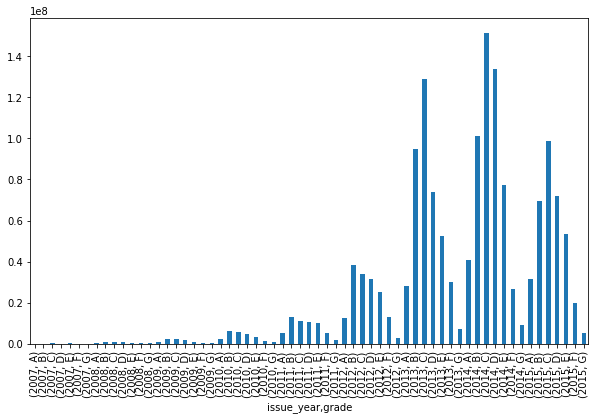

In [30]:
g['total_rec_int'].sum().plot(kind='bar')

In [31]:
g2 = g['total_rec_int'].sum()
g2.index


MultiIndex(levels=[[1, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], [u'A', u'B', u'C', u'D', u'E', u'F', u'G']],
           labels=[[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9], [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]],
           names=[u'issue_year', u'grade'])

In [32]:
type(g2)

pandas.core.series.Series

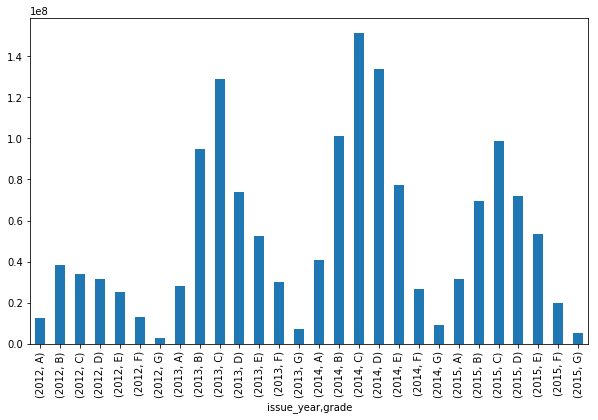

In [33]:
g2.loc[2012:2015].plot(kind='bar')

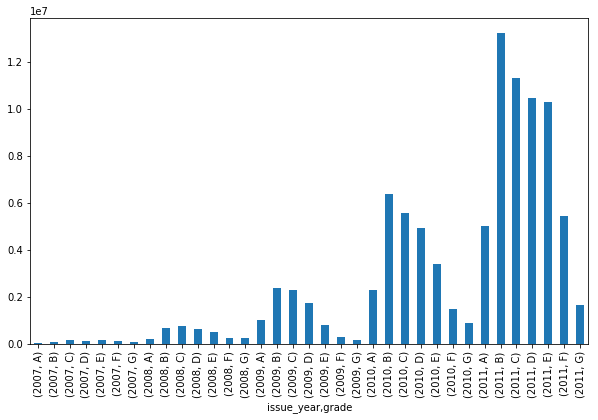

In [34]:
g2.loc[2007:2011].plot(kind='bar')

It appears there was a change in 2012-2013.  Since 2013, C-grade loans have generated the most interest revenue. There was also a dramatic increase in the overall business in 2013.  Models generally benefit from specificity.  Let's select out 2013 C-grade loans for our first model.

Older loans have a greater chance of default.  Since these data are from the end of 2015, using 2013 data will give us the chance for default within 2-3 years.

In [35]:
# conditions
c1 = df.issue_year == 2013
c2 = df.grade == 'C'

df_selected = df.loc[c1 & c2].copy()

In [36]:
df_selected[['grade', 'issue_datetime']].describe()

,grade,issue_datetime
count,38113,38113
unique,1,12
top,C,2013-10-01 00:00:00
freq,38113,4152


In [37]:
df_selected.head()

,member_id,funded_amnt_inv,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,application_type,issue_datetime,issue_year
id,,,,,,,,,,,,,,,,,,,,,
10159584,12011200.0,9750.0,9750.0,13.98%,333.14,C,C1,1 year,RENT,26000.0,...,7967.0,52.8%,28.0,7994.83,6039.04,1955.79,0.0,INDIVIDUAL,2013-12-01 00:00:00,2013
10129403,11981032.0,7550.0,7550.0,16.24%,266.34,C,C5,3 years,RENT,28000.0,...,5759.0,72%,5.0,6407.38,4618.52,1788.86,0.0,INDIVIDUAL,2013-12-01 00:00:00,2013
10224583,12086734.0,11100.0,11100.0,14.98%,384.68,C,C3,10+ years,MORTGAGE,90000.0,...,6619.0,66.2%,12.0,9231.84,6837.40,2394.44,0.0,INDIVIDUAL,2013-12-01 00:00:00,2013
10148818,12000415.0,15000.0,15000.0,14.47%,516.10,C,C2,10+ years,RENT,98000.0,...,5749.0,22.3%,16.0,15699.03,14999.99,699.04,0.0,INDIVIDUAL,2013-12-01 00:00:00,2013
10089634,11941167.0,20000.0,20000.0,16.24%,488.92,C,C5,3 years,RENT,72000.0,...,20480.0,72.1%,32.0,11733.97,6140.23,5593.74,0.0,INDIVIDUAL,2013-12-01 00:00:00,2013


Let's solidify what we are going to predict.  This is known as the target variable.

In [38]:
df_selected.loan_status.unique()

array([u'Current', u'Fully Paid', u'Charged Off', u'Late (31-120 days)',
       u'Late (16-30 days)', u'In Grace Period', u'Default'], dtype=object)

Since the classifier we're using is binary (predicts a zero or one, given the input data), we'll need to encode our target variable, the loan status.

In [39]:
def map_status(status):
    label = 1 if status in ('Current', 'Fully Paid', 'In Grace Period') else 0
    return label

In [40]:
map_status('Current')

1

In [41]:
map_status('foo')

0

In [42]:
df_selected['target'] = df_selected.loan_status.map(map_status)

In [43]:
df_selected[['loan_status', 'target']].sample(10)

,loan_status,target
id,,
4556858,Fully Paid,1
9866464,Fully Paid,1
3728068,Charged Off,0
3810667,Current,1
8356018,Fully Paid,1
3381491,Current,1
3158516,Fully Paid,1
4276983,Current,1
9026911,Current,1


# Model build

# Prepare data for machine learning algorithms

I have decision trees in mind, which makes life easier.  We can mix numerical and categorical data.  We don't need to scale or normalize.  Decision trees divide the dataset according to rules such as "dti < 17.2" etc.  Decision trees are also very dependable and understandable.  I like to use them as a starting point whenever possible.

For a  first pass, let's include only numerical data and drop NAs.  Categorical/cardinal data will require some extra pre-processing.
I'm also going to add a composite metric called 'loan bigness', simply
the monthly installment divided by the monthly income.

In [44]:
import numpy as np

columns = [
        'funded_amnt', # num
        'installment', # num
        'annual_inc', # num
        'dti', # num
        'open_acc', # num
        'revol_bal', # num
        'inq_last_6mths', # num
        'mths_since_last_delinq', # num
        'target'
        #'emp_length', # cardinal
        #'home_ownership', # categorical
        #'purpose' # categorical 
    ]

all_data = df_selected[columns].copy()
all_data['loan_bigness'] = all_data.installment / (all_data.annual_inc / 12.0) # generates some inf
all_data.replace([np.inf, -np.inf], np.nan, inplace=True)
all_data = all_data.dropna() # dropNA's eliminates about half the training data

# prepare the target (what we're going to predict)
all_input = all_data.drop('target', 1)
all_target = all_data.target.copy()



In [45]:
all_input.describe()

,funded_amnt,installment,annual_inc,dti,open_acc,revol_bal,inq_last_6mths,mths_since_last_delinq,loan_bigness
count,17129.000000,17129.000000,1.712900e+04,17129.000000,17129.000000,17129.000000,17129.000000,17129.000000,17129.000000
mean,14580.423551,442.986312,7.369360e+04,17.395184,11.308891,14791.527818,0.825617,34.216183,0.080180
std,8145.559811,248.068337,4.537303e+04,7.581871,4.588666,16669.491637,1.031162,21.545351,0.038533
min,1000.000000,34.030000,9.729000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.001711
25%,8400.000000,279.720000,4.700000e+04,11.680000,8.000000,6509.000000,0.000000,16.000000,0.051508
50%,12250.000000,386.760000,6.500000e+04,17.000000,11.000000,11032.000000,1.000000,31.000000,0.075176
75%,20000.000000,538.400000,8.800000e+04,23.020000,14.000000,18457.000000,1.000000,49.000000,0.105177
max,35000.000000,1252.560000,1.300000e+06,34.990000,62.000000,509875.000000,6.000000,149.000000,0.193254


In [46]:
all_target.describe()

count    17129.000000
mean         0.871855
std          0.334261
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: target, dtype: float64

In [47]:
all_target.index

Index([u'10224583', u'10109669', u'8617375', u'10099585', u'10109703',
       u'10117493', u'10159475', u'10119428', u'10099426', u'10139417',
       ...
       u'2308283', u'2476873', u'2476859', u'2485947', u'2484781', u'2445224',
       u'2383167', u'2382039', u'2381883', u'2371355'],
      dtype='object', name=u'id', length=17129)

In [48]:
all_target.head(5), all_input.head(5)

(id
 10224583    1
 10109669    1
 8617375     0
 10099585    1
 10109703    1
 Name: target, dtype: int64,
           funded_amnt  installment  annual_inc    dti  open_acc  revol_bal  \
 id                                                                           
 10224583      11100.0       384.68     90000.0   3.73       9.0     6619.0   
 10109669      20000.0       683.36     80000.0  16.70      10.0    12948.0   
 8617375       10000.0       232.58     25000.0  27.03      13.0     5394.0   
 10099585      18450.0       630.40     65000.0  15.84      14.0    20803.0   
 10109703       8325.0       291.09     65000.0   5.71       5.0     6363.0   
 
           inq_last_6mths  mths_since_last_delinq  loan_bigness  
 id                                                              
 10224583             0.0                    16.0      0.051291  
 10109669             1.0                     8.0      0.102504  
 8617375              0.0                    63.0      0.111638  
 100995

In [49]:
from sklearn.cross_validation import train_test_split
train_data, test_data, train_target, test_target = train_test_split(all_input, all_target, test_size=0.2)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [50]:
?train_test_split

In [51]:
train_data.head()

,funded_amnt,installment,annual_inc,dti,open_acc,revol_bal,inq_last_6mths,mths_since_last_delinq,loan_bigness
id,,,,,,,,,
6170018,12000.0,417.28,53700.0,5.45,6.0,4902.0,0.0,48.0,0.093247
6906362,17050.0,407.59,85000.0,27.02,14.0,17752.0,0.0,7.0,0.057542
8756058,5875.0,207.13,50000.0,16.87,9.0,6502.0,2.0,28.0,0.049711
3445770,27050.0,941.81,130000.0,20.99,17.0,37552.0,0.0,12.0,0.086936
5758107,18000.0,431.16,108000.0,5.62,9.0,16477.0,0.0,16.0,0.047907


In [52]:
test_data.head()

,funded_amnt,installment,annual_inc,dti,open_acc,revol_bal,inq_last_6mths,mths_since_last_delinq,loan_bigness
id,,,,,,,,,
4555000,26375.0,659.33,60000.0,9.22,11.0,12394.0,0.0,28.0,0.131866
10117284,9175.0,320.81,80000.0,20.25,7.0,7959.0,0.0,68.0,0.048121
8967978,8000.0,279.72,85000.0,3.06,5.0,46783.0,1.0,21.0,0.039490
4288613,35000.0,1201.84,150000.0,6.08,9.0,44149.0,3.0,21.0,0.096147
6187050,13000.0,321.55,40000.0,12.54,7.0,15446.0,1.0,33.0,0.096465


In [53]:
test_data.loan_bigness.describe()

count    3426.000000
mean        0.079981
std         0.038142
min         0.001711
25%         0.052011
50%         0.075183
75%         0.104199
max         0.193254
Name: loan_bigness, dtype: float64

Let's have a look at how many good/bad loans we have in the testing an training sets

In [54]:
train_target.describe() # looks like 13% bad loans

count    13703.000000
mean         0.873166
std          0.332799
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: target, dtype: float64

In [55]:
test_target.describe() # similar percentage of bad loans

count    3426.000000
mean        0.866608
std         0.340047
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

We have a low percentage of bad loans.  Keep this in mind when we evaluate our classifier.  If we just say, "all grade 2013 C loans are good", we will be 87% accurate.  

In [56]:
train_target.index[0:5], train_data.index[0:5] # just checking :)

(Index([u'6170018', u'6906362', u'8756058', u'3445770', u'5758107'], dtype='object', name=u'id'),
 Index([u'6170018', u'6906362', u'8756058', u'3445770', u'5758107'], dtype='object', name=u'id'))

In [57]:
test_target.index[0:5], test_data.index[0:5]

(Index([u'4555000', u'10117284', u'8967978', u'4288613', u'6187050'], dtype='object', name=u'id'),
 Index([u'4555000', u'10117284', u'8967978', u'4288613', u'6187050'], dtype='object', name=u'id'))

In [58]:
# if you want to re-run this including categorical variables, you can start here to figure out what needs to be encoded
#print df_train.emp_length.unique()
#print df_train.home_ownership.unique()
#print df_train.purpose.unique()

## Feature Selection

A subject-matter expert (SME) is usually the best feature selector.  Automated feature selection is also important.  Automated selection is best used to validate and/or enhance the SME's advice.  Scikit learn has a variety of feature selectors.  We will try a few here.  Reference:

http://scikit-learn.org/stable/modules/feature_selection.html


### ExtraTreesClassifier

This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier



In [59]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier

In [60]:
forest = ExtraTreesClassifier(n_estimators=100)
forest.fit(train_data, train_target)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Following was adapted to our problem from this example:
http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#example-ensemble-plot-forest-importances-py

In [61]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [62]:
indices

array([8, 3, 7, 5, 2, 1, 4, 0, 6])

In [63]:
train_data.columns[indices]  # names

Index([u'loan_bigness', u'dti', u'mths_since_last_delinq', u'revol_bal',
       u'annual_inc', u'installment', u'open_acc', u'funded_amnt',
       u'inq_last_6mths'],
      dtype='object')

In [64]:
# Print the feature ranking
print("Feature ranking:")

for f in range(train_data.shape[1]):
    print("%d. %s (%f)" % (f + 1, train_data.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. loan_bigness (0.125716)
2. dti (0.125269)
3. mths_since_last_delinq (0.124826)
4. revol_bal (0.123524)
5. annual_inc (0.115057)
6. installment (0.114896)
7. open_acc (0.114628)
8. funded_amnt (0.104573)
9. inq_last_6mths (0.051512)


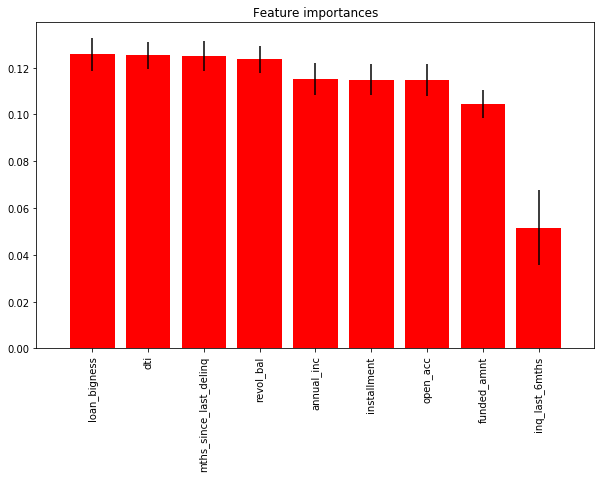

In [65]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_data.shape[1]), train_data.columns[indices], rotation=90)
plt.xlim([-1, train_data.shape[1]])
plt.show()

let's go with `dti`, `revol_bal`, `loan_bigness`, and `mths_since_last_delinq` for our initial model

In [66]:
model_features=['dti', 'revol_bal', 'loan_bigness', 'mths_since_last_delinq']

train_data = train_data[model_features].copy()
test_data = test_data[model_features].copy()

train_data.head()

,dti,revol_bal,loan_bigness,mths_since_last_delinq
id,,,,
6170018,5.45,4902.0,0.093247,48.0
6906362,27.02,17752.0,0.057542,7.0
8756058,16.87,6502.0,0.049711,28.0
3445770,20.99,37552.0,0.086936,12.0
5758107,5.62,16477.0,0.047907,16.0


## Train the Model
It's rather anti-climatic.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

When you want to predict a numerical value target (regression, as opposed to what we are doing now: predicting a label), use the random forest regressor:

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Model evaluation will be different, but everything else is the same.

###### (Optional-- for comparison to random forest: Train a logistic regression classifier)

In [67]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_data, train_target)
lr_probs = lr.predict_proba(test_data)

In [68]:
lr_probs

array([[ 0.21708986,  0.78291014],
       [ 0.08373021,  0.91626979],
       [ 0.13810176,  0.86189824],
       ..., 
       [ 0.04266497,  0.95733503],
       [ 0.10533277,  0.89466723],
       [ 0.21836325,  0.78163675]])

#### Train a random forest classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, max_features=3)

In [71]:
rf.fit(train_data, train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Let's have a look at the decision trees we've trained!

In [72]:
len(rf.estimators_)

100

In [73]:
rf.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1542546938, splitter='best')

As expected, our random forest consists of 100 DecisionTreeClassifiers.

In [74]:
from sklearn.tree import export_graphviz
export_graphviz(rf.estimators_[0], out_file='/Users/pfigliozzi/pers/mlclass/small_tree0.dot')

In [75]:
export_graphviz(rf.estimators_[1], out_file='/Users/pfigliozzi/pers/mlclass/small_tree1.dot')

To view this file in Windows: install Graphviz viewer
    http://www.graphviz.org/
    
Mac: `brew install graphviz`, then `dot -Tpng small_tree0.dot > small_tree0.png`

Linux: `sudo apt-get install graphviz` then as Mac
    
Gini impurity is $1 - \Sigma p_i ^2$. Zero means there is only one class in the set (the probability of being in that class is 100%.)  Gini impurity is maximized when the chances for each class are equal.  In this case, with two classes, it's $1 - (0.5^2 + 0.5^2) = 1 - 0.5 = 0.5$.  For our 2013 data, it's 87% good loans, so Gini = $1 - 0.87^2 - 0.13^2 = 0.226$.

## Use the model to classify our test (future) data

In [76]:
test_data.describe()

,dti,revol_bal,loan_bigness,mths_since_last_delinq
count,3426.000000,3426.000000,3426.000000,3426.000000
mean,17.596503,15028.125803,0.079981,33.833333
std,7.469613,17350.119717,0.038142,21.445663
min,0.070000,0.000000,0.001711,0.000000
25%,11.960000,6620.750000,0.052011,16.000000
50%,17.200000,11280.000000,0.075183,30.000000
75%,23.087500,18633.750000,0.104199,48.000000
max,34.990000,323821.000000,0.193254,94.000000


Query predictive model with all test data, for purposes of testing
the effectiveness

In [77]:
probs = rf.predict_proba(test_data)
probs

array([[ 0.16218521,  0.83781479],
       [ 0.11472912,  0.88527088],
       [ 0.09773971,  0.90226029],
       ..., 
       [ 0.16132924,  0.83867076],
       [ 0.0998562 ,  0.9001438 ],
       [ 0.1492779 ,  0.8507221 ]])

#### Query an individual loan applicant
This must be calibrated before you use it; in my opinion it's easer to use predict_proba.
See here: http://scikit-learn.org/stable/modules/calibration.html

In [78]:
rf.predict(np.array([105.0, 2000000, 0.21, 1]).reshape(1,-1))

array([1])

# Model evaluation
Receiver operating characteristic curves are almost always the best way to evaluate if your classifier is actually working.

Justification: http://www.hpl.hp.com/techreports/2003/HPL-2003-4.pdf

I encourage you to test and explore the conslusions of that paper.
I feel there are too many bad examples of model evaluation online.  The paper will get you going in the right direction.

Let's see what the ROC curve says about our classifier.  We'll also check out AUC (**A**rea **U**nder the roc **C**urve), a related metric.

In [79]:
from sklearn.metrics import roc_curve, auc

In [80]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(test_target, probs[:, 1])
roc_auc = auc(fpr, tpr)
print roc_auc


0.570069787513


_(Optional, only if you trained the logistic regression model before )_

In [81]:
# Compute ROC curve and area the curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(test_target, lr_probs[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
print roc_auc_lr


NameError: name 'lr_probs' is not defined

In [81]:
fpr

array([ 0.        ,  0.00437637,  0.00437637, ...,  0.99781182,
        1.        ,  1.        ])

In [82]:
thresholds

array([ 1.90693599,  0.90693599,  0.90664925, ...,  0.82473519,
        0.82336224,  0.8166549 ])

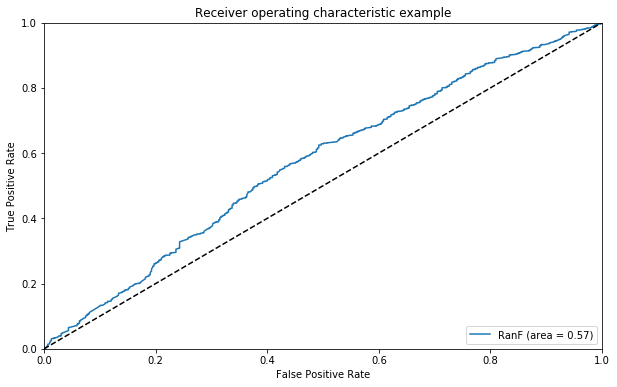

In [83]:
# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='RanF (area = %0.2f)' % roc_auc)
#plt.plot(fpr_lr, tpr_lr, label='LR (area = %0.2f)' % roc_auc_lr)
#pl.plot(fpr2, tpr2, label='KNN(3) (area = %0.2f)' % roc_auc2)
#pl.plot(fpr3, tpr3, label='KNN(21) (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

If our classifier was doing a great job (it's not), the blue line would move up and left.  The AUC would increase well above 0.50.

Just to drive the point home about using ROC curves and AUC instead of the built-in accuracy metric:

In [84]:
rf.score(test_data, test_target)

0.86660828955049618

# Conclusion

Our ROC curve suggests we can predict that some C-grade loans will have a greater chance of default.  The next steps are to further verify and optimize our model. (Different settings for the random forest parameters; inclusion or removal of different input data variables). Sci-kit learn has a pipeline and grid search object for this specific purpose.  You will also want to learn about cross-validation.